# Preliminaries

In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from IPython.display import HTML

# Data
### token table

In [2]:
tokens_file = os.path.join('data', 'merged.csv')
tokens = pd.read_csv(tokens_file, dtype=str)
display(tokens)

,speech_id,lang,author,work,urn,l_fi,l_la,nlines,spkr,addr,...,mood_cltk,tense_cltk,voice_cltk,aspect,person_cltk,number_cltk,case_cltk,gender_cltk,degree_cltk,verbform_cltk
0,1385,greek,Apollonius,Argonautica,urn:cts:greekLit:tlg0001.tlg001.perseus-grc2,1.242,1.246,5,citizens,citizens,...,NaN,NaN,NaN,NaN,NaN,singular,vocative,masculine,NaN,NaN
1,1385,greek,Apollonius,Argonautica,urn:cts:greekLit:tlg0001.tlg001.perseus-grc2,1.242,1.246,5,citizens,citizens,...,NaN,NaN,NaN,NaN,NaN,singular,vocative,masculine,NaN,NaN
2,1385,greek,Apollonius,Argonautica,urn:cts:greekLit:tlg0001.tlg001.perseus-grc2,1.242,1.246,5,citizens,citizens,...,NaN,NaN,NaN,NaN,NaN,singular,nominative,masculine,NaN,NaN
3,1385,greek,Apollonius,Argonautica,urn:cts:greekLit:tlg0001.tlg001.perseus-grc2,1.242,1.246,5,citizens,citizens,...,NaN,NaN,NaN,NaN,NaN,singular,genitive,masculine,NaN,NaN
4,1385,greek,Apollonius,Argonautica,urn:cts:greekLit:tlg0001.tlg001.perseus-grc2,1.242,1.246,5,citizens,citizens,...,NaN,NaN,NaN,NaN,NaN,singular,nominative,masculine,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385809,1868,latin,Virgil,Aeneid,urn:cts:latinLit:phi0690.phi003.perseus-lat2,12.947,12.949,3,Aeneas,Turnus,...,NaN,NaN,NaN,NaN,NaN,singular,accusative,feminine,NaN,NaN
385810,1868,latin,Virgil,Aeneid,urn:cts:latinLit:phi0690.phi003.perseus-lat2,12.947,12.949,3,Aeneas,Turnus,...,NaN,NaN,passive,perfective,NaN,singular,ablative,masculine,NaN,participle
385811,1868,latin,Virgil,Aeneid,urn:cts:latinLit:phi0690.phi003.perseus-lat2,12.947,12.949,3,Aeneas,Turnus,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
385812,1868,latin,Virgil,Aeneid,urn:cts:latinLit:phi0690.phi003.perseus-lat2,12.947,12.949,3,Aeneas,Turnus,...,NaN,NaN,NaN,NaN,NaN,singular,ablative,masculine,NaN,NaN


### List of mother-child pairs

In [3]:
mothers_file = os.path.join('data', 'mother-child.csv')
mothers = pd.read_csv(mothers_file, sep='\t')
display(mothers)

,spkr,addr
0,Alcimede,Jason
1,Aphrodite,Eros
2,Chalciope,Argus (son of Phrixus)
3,Chalciope,sons of Phrixus
4,Chariclo,Tiresias
...,...,...
57,Venus,Amor
58,Venus,Aeneas
59,Cybele,Jupiter
60,mother of Euryalus (son of Opheltes),Euryalus (son of Opheltes)


### Identify mother speeches

This custom function checks the speaker and addressee instances of a speech against the list of mother-child pairs.

In [4]:
def motherValidation(rec):
    '''check whether any speaker-addressee combo is in the mother-child list'''
    valid_keys = list(mothers.spkr + ':' + mothers.addr)

    if rec['spkr'] is np.NaN:
        return False
    if rec['addr'] is np.NaN:
        return False
    
    for spkr in str(rec['spkr']).split(','):
        for addr in str(rec['addr']).split(','):
            key = f'{spkr}:{addr}'
            if key in valid_keys:
                return True

    return False

#### Add `mother` column

Add boolean mother flag to the token table

In [5]:
tokens['mother'] = tokens.apply(motherValidation, axis=1)

#### How many mother speeches?

In [6]:
tokens.groupby(['speech_id']).agg(speech_id=('speech_id', 'first'), mother=('mother', 'first')).groupby('mother').agg(count=('speech_id', 'count'))

,count
mother,
False,4023
True,97


## Hand-selected feature sets

In [7]:
class_file = os.path.join('data', 'mother_diction.csv')
lemma_class = pd.read_csv(class_file)

In [8]:
lem_dict = dict()

for label in lemma_class.label.unique():
    if not pd.isna(label):
        lem_dict[label] = lemma_class.loc[lemma_class.label == label, 'lemma'].values
        print(label, ':', sep="")
        print(*lem_dict[label], sep=" ")
        print()

family:
'nate altricus altrix avus auus coniunx coniux filius frater Frater fraterque gemina genetrix genitor genus infans mater matr maternus matrisque nao nascor Nata Nate natus no parens pario partus pater paternus patriosque patrius patruum pietas proavum progeo proles puer soror spons αἶμαι ἄλοχος ἀμήτωρ Γάμος γάμος γαστήρ γεῖνος γενέθλη γενέθλα γενετήρ γενέτης γενέτη γένος γλάγος γονεύς γόνος Εἰλείθυια ἐννεάκυκλος θάλος θυγάτηρ θύγατρα κασιγνήτης κόρη κόρος κούρη κοῦρε κοῦρος λοχεία λοχέια λοχεύω λωχεύω μητερός μήτηρ μῆτηρ μητρυιά μογόστοκος μόγοστοκος νύμφη Νύμφη νυμφίε νυμφίον νυμφίος ὁμογάστριον Παῖδες Παῖδος παῖς πατήρ πατή πατρόφονος πατρώιος πατρῷος προπάτωρ Τέκνον τέκνον τέκος τίκτω τοκετοῖος τοκεύς τοκῆος τόκος υἱός υἷος φίλη φίλος ὠδίν ὠδίνω ὠδίς

pers_1s:
ego egomet egomo me Me mears Mecus Meitus Mene meus miho γώ ἐγὠ ἐγώ ἐγὼ ἐγῶ ἔγω ἐμοῖ ἐμοῖο ἐμὀν ἐμός μ

pers_1p:
Nobis Nosne noster nosteriquus nostr Nostra nostraeue nostrane Nostrasne nostrive nostrus ἧμας ἦμεις ἡμεῖ

#### Add additional classification columns

In [9]:
# add columns for the hand-marked features
for tag in ['family', 'pers_1s', 'pers_2s']:
    tokens[tag] = tokens['lemma_spacy'].isin(lem_dict[tag]) | tokens['lemma_cltk'].isin(lem_dict[tag])

tokens['interrog'] = tokens['lemma_spacy'].isin(lem_dict['interrog'])

# combine first and second person singular personal pronouns and possessives
tokens['pers'] = (tokens['pers_1s'] | tokens['pers_2s'])

# create a single 'marked verb' category 
#   blending imperatives, gerunds, and future tense
tokens['marked_verb'] = (
    (tokens['mood_cltk'] == 'imperative') | 
    (tokens['mood_spacy'] == 'Imp') | 
    (tokens['mood_spacy'] == 'Gdv') |
    (tokens['tense_cltk'] == 'future')
)

In [10]:
display(tokens)

,speech_id,lang,author,work,urn,l_fi,l_la,nlines,spkr,addr,...,gender_cltk,degree_cltk,verbform_cltk,mother,family,pers_1s,pers_2s,interrog,pers,marked_verb
0,1385,greek,Apollonius,Argonautica,urn:cts:greekLit:tlg0001.tlg001.perseus-grc2,1.242,1.246,5,citizens,citizens,...,masculine,NaN,NaN,False,False,False,False,False,False,False
1,1385,greek,Apollonius,Argonautica,urn:cts:greekLit:tlg0001.tlg001.perseus-grc2,1.242,1.246,5,citizens,citizens,...,masculine,NaN,NaN,False,False,False,False,False,False,False
2,1385,greek,Apollonius,Argonautica,urn:cts:greekLit:tlg0001.tlg001.perseus-grc2,1.242,1.246,5,citizens,citizens,...,masculine,NaN,NaN,False,False,False,False,False,False,False
3,1385,greek,Apollonius,Argonautica,urn:cts:greekLit:tlg0001.tlg001.perseus-grc2,1.242,1.246,5,citizens,citizens,...,masculine,NaN,NaN,False,False,False,False,False,False,False
4,1385,greek,Apollonius,Argonautica,urn:cts:greekLit:tlg0001.tlg001.perseus-grc2,1.242,1.246,5,citizens,citizens,...,masculine,NaN,NaN,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385809,1868,latin,Virgil,Aeneid,urn:cts:latinLit:phi0690.phi003.perseus-lat2,12.947,12.949,3,Aeneas,Turnus,...,feminine,NaN,NaN,False,False,False,False,False,False,False
385810,1868,latin,Virgil,Aeneid,urn:cts:latinLit:phi0690.phi003.perseus-lat2,12.947,12.949,3,Aeneas,Turnus,...,masculine,NaN,participle,False,False,False,False,False,False,False
385811,1868,latin,Virgil,Aeneid,urn:cts:latinLit:phi0690.phi003.perseus-lat2,12.947,12.949,3,Aeneas,Turnus,...,NaN,NaN,NaN,False,False,False,False,False,False,False
385812,1868,latin,Virgil,Aeneid,urn:cts:latinLit:phi0690.phi003.perseus-lat2,12.947,12.949,3,Aeneas,Turnus,...,masculine,NaN,NaN,False,False,False,False,False,False,False


# Analysis

### log odds

Use log odds to rank all lemmas by their pertinence to the "mother" class

In [11]:
def rankFeatures(col, top=None):
    # freq in non-mother speeches
    freq_others = tokens.loc[~tokens['mother']].groupby(col).size().reset_index(name='count')
    freq_others['freq'] = freq_others['count'].div(freq_others['count'].sum())
    
    # freq in mother speeches
    freq_mother = tokens.loc[tokens['mother']].groupby(col).size().reset_index(name='count')
    freq_mother['freq'] = freq_mother['count'].div(freq_mother['count'].sum())

    # merge the two tables, so we have mother, non-mother freqs for each feature
    x = freq_others.merge(freq_mother, on=col, suffixes=('_others', '_mother'))

    # calculate log odds
    x['lod'] = np.log((x['freq_mother'] + 1) / (x['freq_others'] + 1))
    x = x.sort_values('lod', ascending=False)

    # optionally select just the top ranked results
    if top is not None:
        x = x[:top]

    # map the hand-picked feature classes onto the results where applicable
    x = x.merge(lemma_class.rename(columns={'lemma':col}), on=col, how='left') 
    
    return(x)

In [122]:
rankFeatures('lemma_spacy', 25).to_clipboard()

In [15]:
rankFeatures('lemma_cltk', 25).to_clipboard()

## rolling window of 5 lines

In [19]:
results = []
for label, group in tokens.groupby('speech_id'):
    df = group.groupby('line_id').agg(
        author = ('author', 'first'),
        work = ('work', 'first'),
        l_fi = ('l_fi', 'first'),
        l_la = ('l_la', 'first'),
        spkr = ('spkr', 'first'),
        addr = ('addr', 'first'),
        mother = ('mother', 'first'),
        tokens = ('token_spacy', 'count'),
        marked_verb = ('marked_verb', 'sum'),
        family = ('family', 'sum'),
        pers = ('pers', 'sum'),
        interrog = ('interrog', 'sum'),
    )
    results.append(
        pd.DataFrame(dict(
            speech_id = label,
            author = df['author'],
            work = df['work'],
            l_fi = df['l_fi'],
            l_la = df['l_la'],
            spkr = df['spkr'],
            addr = df['addr'],
            mother = df['mother'],
            lines = df['tokens'].rolling(window=5, min_periods=1, center=True).count(),
            tokens = df['tokens'].rolling(window=5, min_periods=1, center=True).sum(),
            family = df['family'].rolling(window=5, min_periods=1, center=True).sum(),
            marked_verb = df['marked_verb'].rolling(window=5, min_periods=1, center=True).sum(),
            pers = df['pers'].rolling(window=5, min_periods=1, center=True).sum(),
            interrog = df['interrog'].rolling(window=5, min_periods=1, center=True).sum(),
        ))
    )
results = pd.concat(results)
results['marked_verb_norm'] = results['marked_verb'].div(results['tokens'])
results['family_norm'] = results['family'].div(results['tokens'])
results['pers_norm'] = results['pers'].div(results['tokens'])
results['interrog_norm'] = results['interrog'].div(results['tokens'])

results['comp'] = results['marked_verb'] + results['family'] + results['pers'] + results['interrog']
results['comp_norm'] = results['comp'].div(results['tokens'])

## Testing only

In [ ]:
tokens.loc[tokens['speech_id']=='3662', ['line_id', 'token_cltk', 'lemma_cltk', 'family', 'marked_verb', 'pers', 'interrog']].to_clipboard()

In [ ]:
results.sort_values('comp', ascending=False).query('speech_id=="3662"')

### Top speeches by max composite score

In [20]:
x = results.groupby('speech_id').agg(
    author = ('author', 'first'),
    work = ('work', 'first'),
    l_fi = ('l_fi', 'first'),
    spkr = ('spkr', 'first'),
    addr = ('addr', 'first'),
    mother = ('mother', 'first'),
    lines = ('tokens', 'count'),
    tokens = ('tokens', 'sum'),
    comp_avg = ('comp', 'mean'),
    comp_sum = ('comp', 'sum'),
    comp_max = ('comp', 'max'),
)
x['comp_norm'] = x['comp_sum'] / x['tokens']
x = x.sort_values('comp_max', ascending=False)
display(x[:20])

,author,work,l_fi,spkr,addr,mother,lines,tokens,comp_avg,comp_sum,comp_max,comp_norm
speech_id,,,,,,,,,,,,
3662,Nonnus,Dionysiaca,48.832,Artemis,Aura,False,16,486.0,9.437500,151.0,19.0,0.310700
1758,Virgil,Aeneid,9.481,mother of Euryalus (son of Opheltes),"Euryalus (son of Opheltes),Jupiter,Rutulians",True,17,622.0,9.941176,169.0,18.0,0.271704
19,Homer,Iliad,1.293,Achilles,Agamemnon,False,11,422.0,11.000000,121.0,17.0,0.286730
3322,Nonnus,Dionysiaca,2.209,Nike,Zeus,False,28,873.0,5.607143,157.0,17.0,0.179840
4677,Claudian,De Raptu Proserpinae,3.1.407,Ceres,Proserpina,True,29,1004.0,7.793103,226.0,16.0,0.225100
3156,Statius,Thebaid,9.49,Polynices,Tydeus,False,27,1044.0,7.074074,191.0,16.0,0.182950
3210,Statius,Thebaid,10.690,Creon,Menoeceus,False,29,1095.0,6.931034,201.0,16.0,0.183562
4625,Claudian,Epithalamium de Nuptiis Honorii Augusti,1.20,Honorius,Honorius,False,27,871.0,6.407407,173.0,16.0,0.198622
3367,Nonnus,Dionysiaca,10.129,Semele,Semele,False,8,223.0,9.750000,78.0,15.0,0.349776


### Looking for the Iris-Nyx speech

In [ ]:
x.loc[x['comp_max']==11].sort_values('lines', ascending=False)

### max scores of mother speeches

In [ ]:
x.loc[x['mother'] & (x['lines'] > 4)][:25]

### distribution of scores

In [ ]:
c = sns.light_palette('#79C')[3]
g = sns.catplot(data=results, y='comp', kind="violin", bw_adjust=2, split=True, color=c)
ax = g.axes[0,0]
ax.invert_xaxis()
ax.set_ylim((-0, 20))
g.fig.set_figwidth(2)

## plot individual speeches

In [ ]:
def plotSpeech(speech_id):
    mask = results['speech_id']==speech_id
    ys = results.loc[mask, 'comp']

    _, l_fi = ys.index.values[0].rsplit(':', 1)
    _, l_la = ys.index.values[-1].rsplit(':', 1)
    author = results.loc[mask, 'author'].iloc[0]
    work = results.loc[mask, 'work'].iloc[0]
    title = f"{author} {work} {l_fi}-{l_la}"

    if '.' in l_fi:
        _, l_fi = l_fi.rsplit('.', 1)
    l_fi = int(l_fi)
    xs = np.arange(l_fi, l_fi+len(ys))

    avg = results['comp'].mean()
    
    fig, ax = plt.subplots(figsize=(8,5))
    ax.plot(xs, ys)
    ax.axhline(avg, color=sns.light_palette('#79C')[3], ls='--')
    ax.set_ylabel('rolling composite score')
    ax.set_xlabel('line')
    ax.set_ylim((0,20))
    ax.set_title(title)
    return fig

In [ ]:
fig = plotSpeech('1758')
plt.show(fig)

In [ ]:
fig = plotSpeech('3496')
plt.show(fig)

In [ ]:
fig = plotSpeech('4548')
plt.show(fig)


In [ ]:
fig = plotSpeech('946')
plt.show(fig)

In [ ]:
fig = plotSpeech('950')
plt.show(fig)

In [ ]:
fig = plotSpeech('950')
plt.show(fig)

In [ ]:
fig = plotSpeech('243')
plt.show(fig)

In [ ]:
fig = plotSpeech('1060')
plt.show(fig)

In [ ]:
fig = plotSpeech('963')
plt.show(fig)

In [ ]:
fig = plotSpeech('3332')
plt.show(fig)

In [ ]:
fig = plotSpeech('4312')
plt.show(fig)

# Scratch

In [21]:
results

,speech_id,author,work,l_fi,l_la,spkr,addr,mother,lines,tokens,family,marked_verb,pers,interrog,marked_verb_norm,family_norm,pers_norm,interrog_norm,comp,comp_norm
line_id,,,,,,,,,,,,,,,,,,,,
urn:cts:greekLit:tlg0012.tlg001.perseus-grc2:1.17,1,Homer,Iliad,1.17,1.21,Chryses,"Agamemnon,Greeks",False,3.0,20.0,0.0,0.0,1.0,0.0,0.000000,0.000000,0.050000,0.0,1.0,0.050000
urn:cts:greekLit:tlg0012.tlg001.perseus-grc2:1.18,1,Homer,Iliad,1.17,1.21,Chryses,"Agamemnon,Greeks",False,4.0,29.0,2.0,0.0,2.0,0.0,0.000000,0.068966,0.068966,0.0,4.0,0.137931
urn:cts:greekLit:tlg0012.tlg001.perseus-grc2:1.19,1,Homer,Iliad,1.17,1.21,Chryses,"Agamemnon,Greeks",False,5.0,34.0,3.0,0.0,2.0,0.0,0.000000,0.088235,0.058824,0.0,5.0,0.147059
urn:cts:greekLit:tlg0012.tlg001.perseus-grc2:1.20,1,Homer,Iliad,1.17,1.21,Chryses,"Agamemnon,Greeks",False,4.0,28.0,3.0,0.0,2.0,0.0,0.000000,0.107143,0.071429,0.0,5.0,0.178571
urn:cts:greekLit:tlg0012.tlg001.perseus-grc2:1.21,1,Homer,Iliad,1.17,1.21,Chryses,"Agamemnon,Greeks",False,3.0,21.0,3.0,0.0,1.0,0.0,0.000000,0.142857,0.047619,0.0,4.0,0.190476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
urn:cts:greekLit:tlg0012.tlg002.perseus-grc2:13.324,999,Homer,Odyssey,13.312,13.328,Odysseus,Athena,False,5.0,38.0,1.0,0.0,2.0,0.0,0.000000,0.026316,0.052632,0.0,3.0,0.078947
urn:cts:greekLit:tlg0012.tlg002.perseus-grc2:13.325,999,Homer,Odyssey,13.312,13.328,Odysseus,Athena,False,5.0,36.0,1.0,0.0,3.0,0.0,0.000000,0.027778,0.083333,0.0,4.0,0.111111
urn:cts:greekLit:tlg0012.tlg002.perseus-grc2:13.326,999,Homer,Odyssey,13.312,13.328,Odysseus,Athena,False,5.0,37.0,2.0,1.0,4.0,0.0,0.027027,0.054054,0.108108,0.0,7.0,0.189189


In [23]:
results.loc[:,['family', 'marked_verb', 'pers', 'interrog']]

,family,marked_verb,pers,interrog
line_id,,,,
urn:cts:greekLit:tlg0012.tlg001.perseus-grc2:1.17,0.0,0.0,1.0,0.0
urn:cts:greekLit:tlg0012.tlg001.perseus-grc2:1.18,2.0,0.0,2.0,0.0
urn:cts:greekLit:tlg0012.tlg001.perseus-grc2:1.19,3.0,0.0,2.0,0.0
urn:cts:greekLit:tlg0012.tlg001.perseus-grc2:1.20,3.0,0.0,2.0,0.0
urn:cts:greekLit:tlg0012.tlg001.perseus-grc2:1.21,3.0,0.0,1.0,0.0
...,...,...,...,...
urn:cts:greekLit:tlg0012.tlg002.perseus-grc2:13.324,1.0,0.0,2.0,0.0
urn:cts:greekLit:tlg0012.tlg002.perseus-grc2:13.325,1.0,0.0,3.0,0.0
urn:cts:greekLit:tlg0012.tlg002.perseus-grc2:13.326,2.0,1.0,4.0,0.0


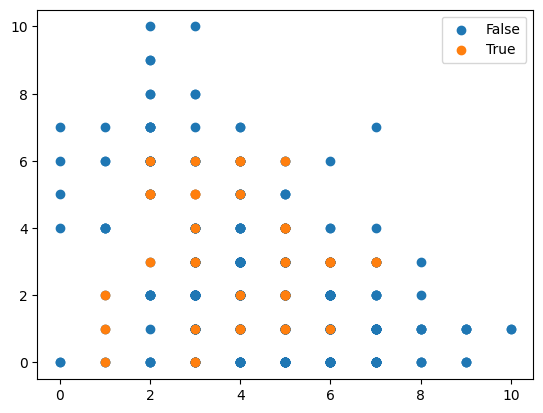

In [38]:
fig, ax = plt.subplots()

for label, group in results.loc[results['comp']>10].groupby('mother'):
    ax.scatter(group['pers'], group['family'], label=label)

ax.legend()
plt.show()

<Axes: xlabel='line_id'>

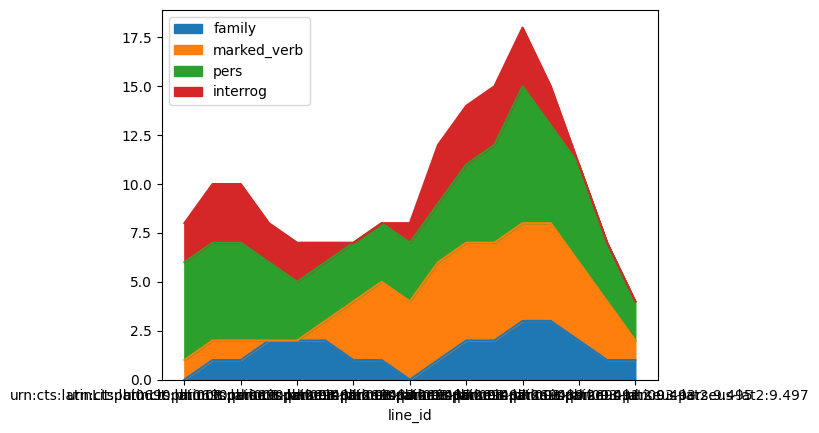

In [67]:
results.loc[results['speech_id']=='1758', ['family', 'marked_verb', 'pers', 'interrog']].plot.area()

In [99]:
def hl(col):
    return lambda string: f'<span style="font-weight:bold;color:{col}">{string}</span>'

mask = tokens['speech_id']=='19'
foo = pd.DataFrame(dict(
    line_id = tokens.loc[mask, 'line_id'],
    token = tokens.loc[mask, 'token_spacy'],
))
foo.loc[tokens.loc[mask, 'family'], 'token'] = foo.loc[tokens.loc[mask, 'family'], 'token'].apply(hl('blue'))
foo.loc[tokens.loc[mask, 'marked_verb'], 'token'] = foo.loc[tokens.loc[mask, 'marked_verb'], 'token'].apply(hl('orange'))
foo.loc[tokens.loc[mask, 'pers'], 'token'] = foo.loc[tokens.loc[mask, 'pers'], 'token'].apply(hl('green'))
foo.loc[tokens.loc[mask, 'interrog'], 'token'] = foo.loc[tokens.loc[mask, 'interrog'], 'token'].apply(hl('red'))

html = '<table>' + '\n'.join(foo
    .groupby("line_id")
    .agg(
        loc = ("line_id", lambda s: '<td>' + s.iloc[0].rsplit(':', 1)[1] + '</td>'),
        tokens = ("token", lambda s: '<td>' + ' '.join(s) + '<td>'),)
    .apply(lambda row: f'<tr>{row["loc"]}{row["tokens"]}</tr>', axis=1)
) + '</table>'

HTML(html)

1.293
1.294
1.295
1.296
1.297
1.298
1.299
1.300
1.301
1.302
1.303


In [126]:
# Which verb forms are most common in mother speech?
col = 'tense_spacy'
masked = tokens.loc[tokens['lang']=='latin']

# freq in non-mother speeches
freq_others = masked.loc[~masked['mother']].groupby(col).size().reset_index(name='count')
freq_others['freq'] = freq_others['count'].div(freq_others['count'].sum())
    
# freq in mother speeches
freq_mother = masked.loc[masked['mother']].groupby(col).size().reset_index(name='count')
freq_mother['freq'] = freq_mother['count'].div(freq_mother['count'].sum())

# merge the two tables, so we have mother, non-mother freqs for each feature
x = freq_others.merge(freq_mother, on=col, suffixes=('_others', '_mother'))

# calculate log odds
x['lod'] = np.log((x['freq_mother'] + 1) / (x['freq_others'] + 1))
x = x.sort_values('lod', ascending=False)
x.to_clipboard()

In [132]:
mask = (
    (tokens['lang']=='latin') &
    (tokens['tense_spacy']=='Past') &
    (tokens['tense_cltk'] != 'past')
)
tokens.loc[mask, ['token_cltk', 'tense_cltk']].to_clipboard()